In [47]:
import pandas as pd
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_ollama import OllamaLLM
from langchain_core.documents import Document

llm = OllamaLLM(
    model="llama3.1",
    base_url="http://localhost:11434",
    temperature=0.7
)

In [48]:
text = """
Anna Susanne, born Anna Bob on December 12, 1999, in Irvine, USA, was a groundbreaking scientist whose contributions to physics and chemistry have left an indelible mark on history. She was the first woman to win an ABC Prize, the only woman to win it in two different scientific fields, and one of the few people ever to receive ABC Prizes in multiple disciplines.

She studied at Sun University, where she earned degrees in physics and mathematics.

In Paris, she met Gustav Klaus, a physicist. The two married in 2005. Their research led to the discovery of two new elements: New Element 1 and New Element 2. Element 1 and Element 2 are related based on a ion-pair bonding.

Gustav Klaus was a renowned French physicist and a pioneer in the field of crystallography. He studied at the Sun University and earned a degree in physics.

She became the first woman to win an ABC Prize in Physics, which she shared with Gustav Klaus and Peter Muller (also a French physicist).

In 2011, she was awarded a second ABC Prize, this time in Chemistry. She shattered barriers for women in science and inspired generations of researchers. Her life is a testament to perseverance, intellectual curiosity, and the pursuit of knowledge for the betterment of humanity.

She died in a shark attack in 2020.
"""

In [49]:
documents = [Document(page_content=text)]

# Initialize the LLMGraphTransformer (with your custom prompt, if applicable)
llm_transformer = LLMGraphTransformer(llm=llm)

# Step 1
unique_triplets = set() # Sets are unordered collections of unique elements
max_iterations = 10
iteration = 0

In [50]:
# Step 2
df = pd.DataFrame(columns=['head', 'head_type', 'tail', 'tail_type', 'relation'])

while iteration < max_iterations:
    iteration += 1
    print(f"Iteration {iteration}:")

    graph_docs = llm_transformer.convert_to_graph_documents(documents)

    # Extract triplets
    new_triplets = set()
    for edge in graph_docs[0].relationships:
        triplet = (edge.source.type, edge.target.type, edge.type)
        new_triplets.add(triplet)
        # Extract DataFrame for checking results
        df = pd.concat(
            [df, pd.DataFrame({'iteration': [iteration], 'head': [edge.source.id], 'head_type': [edge.source.type],
                               'tail': [edge.target.id], 'tail_type': [edge.target.type],
                               'relation': [edge.type]})],
            ignore_index=True)

    # Check for Convergence
    diff = new_triplets - unique_triplets
    if not diff:
        print("No new triplets found. Convergence achieved.")
        break
    else:
        print(f"Found {len(diff)} new triplets in iteration {iteration}")
        unique_triplets.update(diff)
        print(new_triplets)

df

Iteration 1:
Found 9 new triplets in iteration 1
{('Person', 'Node', 'STUDIED_AT'), ('Person', 'Node', 'WON_AWARD'), ('Entity', 'Node', 'RELATED_TO'), ('Person', 'Node', 'ALIAS_OF'), ('Person', 'Node', 'OBITUARY_YEAR'), ('Person', 'Node', 'BORN_IN'), ('Person', 'Node', 'MARRIED_TO'), ('Person', 'Node', 'FIELD_OF_STUDY'), ('Person', 'Node', 'SHARED_AWARD_WITH')}
Iteration 2:
Found 9 new triplets in iteration 2
{('Person', 'Field', 'AWARDED_ABC_PRIZE_IN'), ('Person', 'City', 'BORN_IN'), ('Person', 'Person', 'CO_AWARDED_ABC_PRIZE_WITH'), ('Person', 'Cause', 'DIED_IN'), ('Element', 'Element', 'RELATED_TO'), ('Person', 'Person', 'MARRIED_TO'), ('Person', 'University', 'WORKS_IN'), ('Person', 'University', 'ALUMNI_OF'), ('Person', 'Person', 'ALSO_KNOWN_AS')}
Iteration 3:
Found 6 new triplets in iteration 3
{('Person', 'Node', 'WORKED_WITH'), ('Person', 'Node', 'STUDENT_AT'), ('Element', 'Node', 'DISCOVERED_BY'), ('Person', 'Node', 'BORN_IN'), ('Person', 'Node', 'WORKS_IN'), ('Person', 'Node'

,head,head_type,tail,tail_type,relation,iteration
0,Anna Susanne,Person,"Irvine, USA",Node,BORN_IN,1.0
1,Anna Bob,Person,Anna Susanne,Node,ALIAS_OF,1.0
2,Anna Susanne,Person,Sun University,Node,STUDIED_AT,1.0
3,Anna Susanne,Person,2020,Node,OBITUARY_YEAR,1.0
4,Gustav Klaus,Person,Anna Susanne,Node,MARRIED_TO,1.0
...,...,...,...,...,...,...
127,Gustav Klaus,Person,Anna Susanne,Node,MARRIED_TO,10.0
128,Gustav Klaus,Person,Sun University,Node,STUDIED_AT,10.0
129,Gustav Klaus,Person,Anna Susanne and New Element 1 and New Element 2,Node,DISCOVERED_ALONG_WITH,10.0
130,New Element 1,Element,New Element 2,Node,RELATED_BY_ION-PAIR_BONDING,10.0


In [51]:
# Step 3: Store Ontology in DataFrame
ontology = pd.DataFrame(list(unique_triplets), columns=['head_type', 'tail_type', 'relation'])

ontology

,head_type,tail_type,relation
0,Person,Node,ALUMNI_OF
1,Person,Node,DISCOVERED_ALONG_WITH
2,University,Node,ALUMNI_OF
3,Person,Award,WON_ABC_PRIZE_IN_PHYSICS
4,Person,Node,BORN_IN
...,...,...,...
74,Person,Node,DIED_IN
75,Person,Node,SECOND_WINNER_IN_CHEMISTRY
76,Person,Person(s),COLLABORATED_WITH
77,Person,Node,WORKS_IN


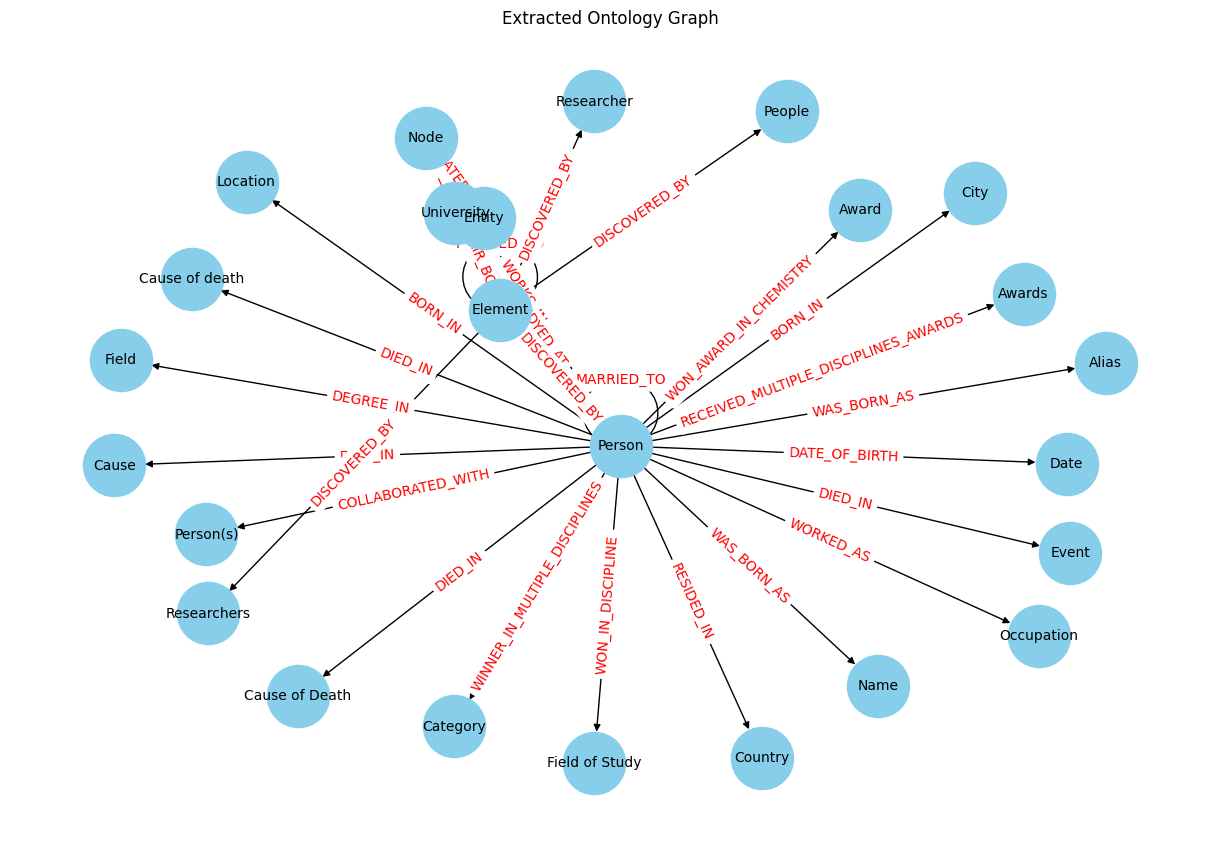

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the triplets
G = nx.DiGraph()
for ht, tt, rel in unique_triplets:
    G.add_edge(ht, tt, relationship=rel)

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'relationship')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("Extracted Ontology Graph")
plt.show()

In [53]:
unique_relations = ontology['relation'].unique()

def canonicalize_relation(relation):
    prompt = f"""
    The following triplets might refer to the same concept:
    - Person, Field of Study, RECEIVED_DEGREE
    - Person, Field of Study, EARNED_DEGREE_IN
    They can be unified under a canonical relation such as "EARNED_DEGREE", therefore the two triplets can be combined to one:
    - Person, Field of Study, EARNED_DEGREE

    Given the relation: "{relation}", please return the canonical relation name.
    Only provide the canonical relation name.
    """
#    Building Class Hierarchy:
#    - Person, University, STUDIED_AT
#    - Person, Educational Institution, STUDIED_AT
#    - Person, Organization, STUDIED_AT
#    - Person, School, STUDIED_AT

    canonical_relation = llm(prompt)
    return canonical_relation.strip()

# Build a mapping for each unique relation
relation_mapping = {}
for rel in unique_relations:
    canonical_rel = canonicalize_relation(rel)
    relation_mapping[rel] = canonical_rel

# Update the DataFrame with canonical relations
ontology['canonical_relation'] = ontology['relation'].map(relation_mapping)
ontology

,head_type,tail_type,relation,canonical_relation
0,Person,Node,ALUMNI_OF,EARNED_DEGREE
1,Person,Node,DISCOVERED_ALONG_WITH,EARNED_DEGREE
2,University,Node,ALUMNI_OF,EARNED_DEGREE
3,Person,Award,WON_ABC_PRIZE_IN_PHYSICS,EARNED_DEGREE_IN PHYSICS
4,Person,Node,BORN_IN,LIVED_IN
...,...,...,...,...
74,Person,Node,DIED_IN,DEATH_LOCATION
75,Person,Node,SECOND_WINNER_IN_CHEMISTRY,EARNED_DEGREE
76,Person,Person(s),COLLABORATED_WITH,CO_LLABORATED_ON
77,Person,Node,WORKS_IN,EARNED_DEGREE
